# Time Lagged Autoencoder Experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with np.load('./data/dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']

# TRAINING DATA: 
print(data_x.shape, data_x.dtype)

# VALIDATION DATA: X + y
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)


(100000, 3) float64
(1000, 3) float64
(1000,) int32


In [2]:
#data_x = np.concatenate((data_x,validation_x))

# Visualization

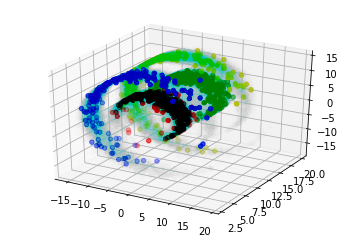

In [3]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = zip(*data_x)
ax.scatter(x,y,z,c='c',alpha=0.005)
for cls, color in enumerate(['r','g','y','b']):
    x,y,z = zip(*validation_x[validation_y == cls])
    ax.scatter(x,y,z,c=color)
    

# Remove mean and correleation (whitening)

In [10]:
def whiten(X,X_val):
    # see: http://cs231n.github.io/neural-networks-2/
    # the matrix X should be observations-by-components
    mean = np.mean(X, axis = 0)
    X_val -= mean
    X -= mean
    
    # get the covariance matrix
    Xcov = np.dot(X.T,X) / X.shape[0]

    # eigenvalue decomposition of the covariance matrix
    val, Vec = np.linalg.eigh(Xcov)
    
    Xrot = np.dot(X, Vec)
    X_val_rot = np.dot(X_val, Vec)
    
    X_white = Xrot / np.sqrt(val + 1e-5)
    X_val_white = X_val_rot / np.sqrt(val + 1e-5)
    return X_white, X_val_white

In [11]:
data_x_white,validation_x_white = whiten(data_x,validation_x)

In [12]:
data_x_white.std(axis=0)

array([ 0.99999967,  0.99999988,  0.99999992])

In [13]:
validation_x_white.std(axis=0)

array([ 0.99644213,  0.97597863,  0.9817804 ])

In [14]:
validation_x_white.mean()

0.0091424848968534502

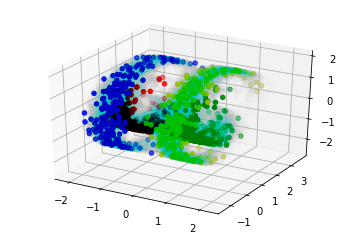

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = zip(*data_x_white)
ax.scatter(x,y,z,c='c',alpha=0.005)
for cls, color in enumerate(['r','g','y','b']):
    x,y,z = zip(*validation_x_white[validation_y == cls])
    ax.scatter(x,y,z,c=color)

# Build time lagged auto encoder

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable

In [17]:
class timeLaggedDataset(torch.utils.data.Dataset):
    def __init__(self, x_array, x_lag, y_lag, overlay=0):
        """
        x_array: array with time dimension at axis=0 
        x_lag: length of x
        y_lag: length of y
        overlay: amount of shared datapoints at end of x and beginning of y
        """
        #x_array = np.expand_dims(x_array, axis=2)
        self.data = torch.from_numpy(x_array).float()

    def __len__(self):
        return len(self.data) - x_lag + 1 - y_lag + overlay

    def __getitem__(self, i):
        return (self.data[i:i+x_lag]).permute(1,0), self.data[i+x_lag-overlay:i+x_lag+y_lag-overlay].permute(1,0)

In [18]:
x_lag = 1
y_lag = 1
overlay = 0
batch_size = 500
lagged_dset = timeLaggedDataset(data_x_white,x_lag,y_lag,overlay)
data_loader = utils.DataLoader(lagged_dset, batch_size=batch_size, shuffle=True)

In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()        
        self.fclayers = nn.Sequential(
            nn.Linear(x_lag*3,100),
            nn.ReLU(),
            nn.Linear(100,2),
        )
                 
    def forward(self,x):

        out = x.view(x.size()[0], -1)
        out = self.fclayers(out)

        return out

    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fclayers = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,y_lag*3),
        )
                                   
    def forward(self,x):
        out = self.fclayers(x)
        out = out.view(x.size()[0],-1,y_lag)
        return out
    


In [20]:
encoder = Encoder()
decoder = Decoder()

In [21]:
loss_func = nn.MSELoss(size_average=True)
for x,y in data_loader:
    print(x.shape,y.shape)
    test = x.view(x.size()[0], -1)
    print(test.shape)
    out = encoder(x)
    print(out.shape)
    out = decoder(out)
    print("loss: ", loss_func(out,y), out.size(), y.size())
    print(out.shape)
    break
    

torch.Size([500, 3, 1]) torch.Size([500, 3, 1])
torch.Size([500, 3])
torch.Size([500, 2])
loss:  tensor(1.0661) torch.Size([500, 3, 1]) torch.Size([500, 3, 1])
torch.Size([500, 3, 1])


In [22]:
learning_rate = 0.001
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss(size_average=False)
for i,weights in enumerate(parameters):
    try:
        torch.nn.init.xavier_uniform_(weights,gain=np.sqrt(2))
        #print("Success!")
    except:
        #print('Failure')
        pass
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [35]:
val_set = timeLaggedDataset(validation_x_white,x_lag,y_lag,overlay)
val_loader = utils.DataLoader(val_set, batch_size=len(val_set), shuffle=False)
def eval_plot():
    encoder.eval()
    decoder.eval()
    pre_val = []
    loss = 0
    for x,y in val_loader:
        out = encoder(x)
        #print(out)
        pre_val = out.detach().numpy()
        out = decoder(out)
        loss += loss_func(out,y)
        break
    pre_val,_ = whiten(pre_val,pre_val)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for cls, color in enumerate(['r','g','y','b']):
        state = pre_val[validation_y[:-x_lag] == cls] #min(-1,-( y_lag - overlay -1))
        x,y = state[:,0],state[:,1]
        ax.scatter(x,y,c=color)
    
    
    plt.show()
    loss /= len(val_loader)
    loss = loss.item()
    print("VAL_LOSS:",loss)
    return loss

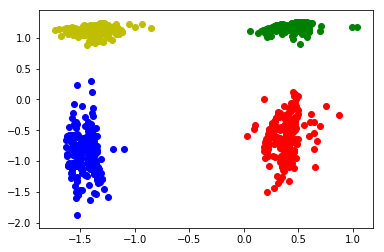

VAL_LOSS: 0.62246173620224


0.62246173620224

In [36]:
eval_plot()

In [25]:
learning_rate = 0.0005
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss(size_average=True)
optimizer = torch.optim.Adam(parameters, lr=learning_rate)


--------model not restored--------



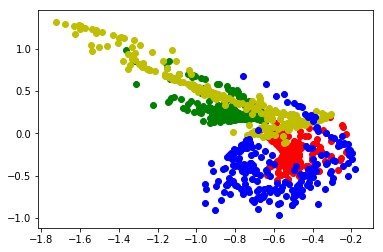

VAL_LOSS: 1.3420419692993164
Train Epoch: 0 [95000/99999 (95%)]	Loss: 0.69075119


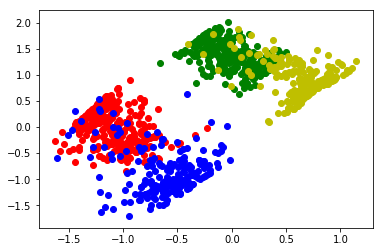

VAL_LOSS: 0.6694316267967224
Train Epoch: 1 [95000/99999 (95%)]	Loss: 0.59533828
Train Epoch: 2 [95000/99999 (95%)]	Loss: 0.65506577


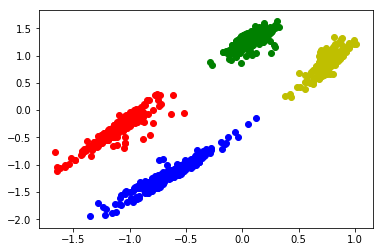

VAL_LOSS: 0.6275180578231812
Train Epoch: 3 [95000/99999 (95%)]	Loss: 0.63218421
Train Epoch: 4 [95000/99999 (95%)]	Loss: 0.64219493


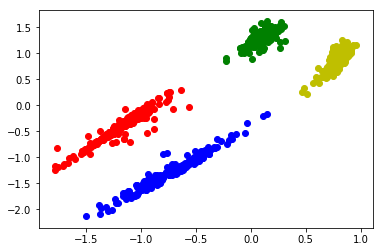

VAL_LOSS: 0.6253634691238403
Train Epoch: 5 [95000/99999 (95%)]	Loss: 0.68444133
Train Epoch: 6 [95000/99999 (95%)]	Loss: 0.60625637


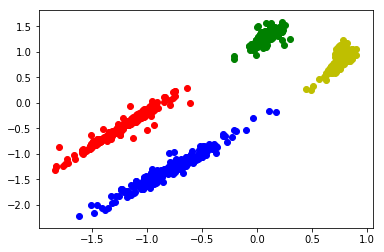

VAL_LOSS: 0.6239208579063416
Train Epoch: 7 [95000/99999 (95%)]	Loss: 0.70673209
Train Epoch: 8 [95000/99999 (95%)]	Loss: 0.62515306


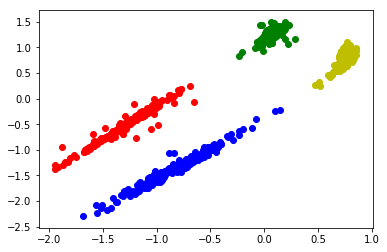

VAL_LOSS: 0.6236931085586548
Train Epoch: 9 [95000/99999 (95%)]	Loss: 0.61491632
Train Epoch: 10 [95000/99999 (95%)]	Loss: 0.62326437


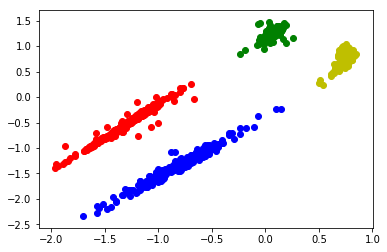

VAL_LOSS: 0.6236090660095215
Train Epoch: 11 [95000/99999 (95%)]	Loss: 0.64269859
Train Epoch: 12 [95000/99999 (95%)]	Loss: 0.64280641


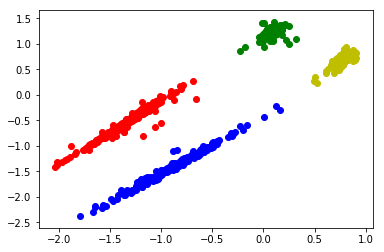

VAL_LOSS: 0.6232388615608215
Train Epoch: 13 [95000/99999 (95%)]	Loss: 0.65909094
Train Epoch: 14 [95000/99999 (95%)]	Loss: 0.59821814


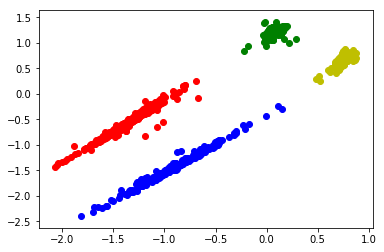

VAL_LOSS: 0.6225021481513977
Train Epoch: 15 [95000/99999 (95%)]	Loss: 0.66762787
Train Epoch: 16 [95000/99999 (95%)]	Loss: 0.63897401


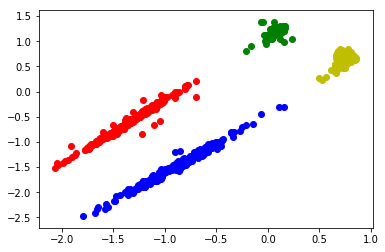

VAL_LOSS: 0.6230902671813965
Train Epoch: 17 [95000/99999 (95%)]	Loss: 0.65123367
Train Epoch: 18 [95000/99999 (95%)]	Loss: 0.62383759


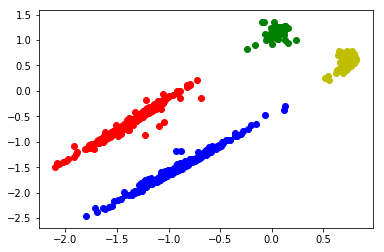

VAL_LOSS: 0.6240683197975159
Train Epoch: 19 [95000/99999 (95%)]	Loss: 0.61329913
Train Epoch: 20 [95000/99999 (95%)]	Loss: 0.61801553


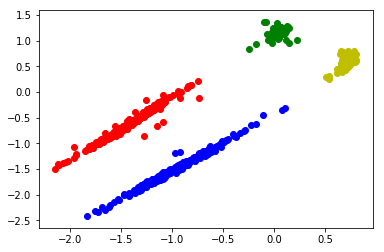

VAL_LOSS: 0.6229619383811951
Train Epoch: 21 [95000/99999 (95%)]	Loss: 0.67078739
Train Epoch: 22 [95000/99999 (95%)]	Loss: 0.63289803


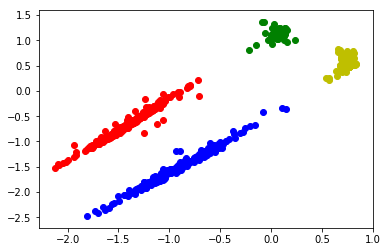

VAL_LOSS: 0.6221418380737305
Train Epoch: 23 [95000/99999 (95%)]	Loss: 0.68529022
Train Epoch: 24 [95000/99999 (95%)]	Loss: 0.65628284


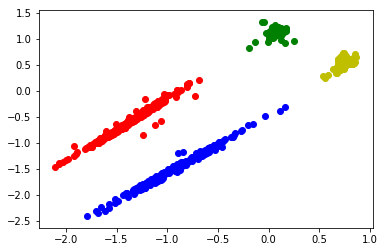

VAL_LOSS: 0.6218187808990479
Train Epoch: 25 [95000/99999 (95%)]	Loss: 0.64770126
Train Epoch: 26 [95000/99999 (95%)]	Loss: 0.63691014


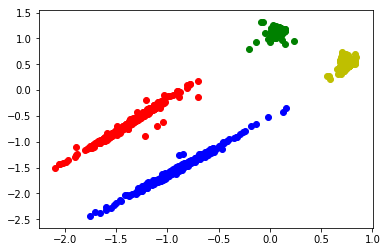

VAL_LOSS: 0.622024416923523
Train Epoch: 27 [95000/99999 (95%)]	Loss: 0.63884157
Train Epoch: 28 [95000/99999 (95%)]	Loss: 0.71650040


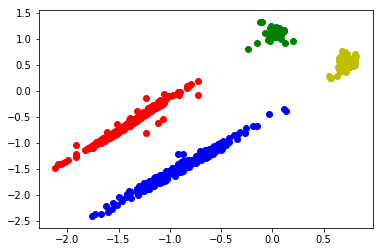

VAL_LOSS: 0.6219661235809326
Train Epoch: 29 [95000/99999 (95%)]	Loss: 0.69441819
Train Epoch: 30 [95000/99999 (95%)]	Loss: 0.64330584


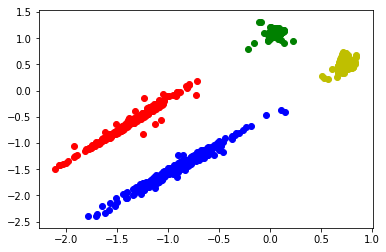

VAL_LOSS: 0.6226083040237427
Train Epoch: 31 [95000/99999 (95%)]	Loss: 0.68367279
Train Epoch: 32 [95000/99999 (95%)]	Loss: 0.64343458


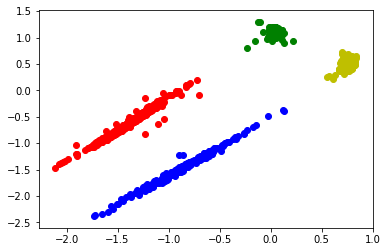

VAL_LOSS: 0.6227323412895203
Train Epoch: 33 [95000/99999 (95%)]	Loss: 0.66608733
Train Epoch: 34 [95000/99999 (95%)]	Loss: 0.64104527


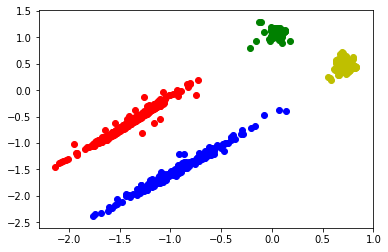

VAL_LOSS: 0.6217238306999207
Train Epoch: 35 [95000/99999 (95%)]	Loss: 0.65785033
Train Epoch: 36 [95000/99999 (95%)]	Loss: 0.69326621


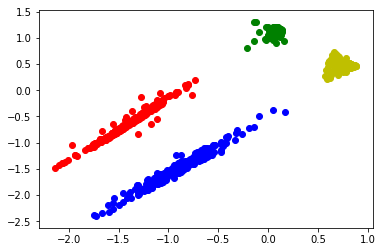

VAL_LOSS: 0.6226320862770081
Train Epoch: 37 [95000/99999 (95%)]	Loss: 0.65001833
Train Epoch: 38 [95000/99999 (95%)]	Loss: 0.64592487


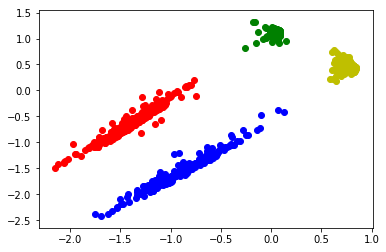

VAL_LOSS: 0.6229085326194763
Train Epoch: 39 [95000/99999 (95%)]	Loss: 0.66798460
Train Epoch: 40 [95000/99999 (95%)]	Loss: 0.64947802


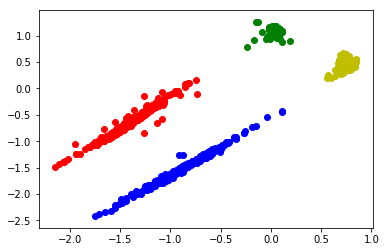

VAL_LOSS: 0.6218860149383545
Train Epoch: 41 [95000/99999 (95%)]	Loss: 0.73474437
Train Epoch: 42 [95000/99999 (95%)]	Loss: 0.75266010


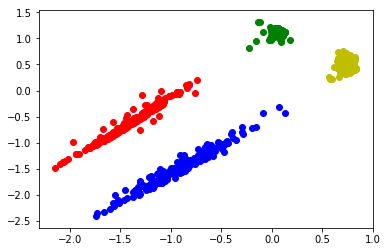

VAL_LOSS: 0.6228383183479309
Train Epoch: 43 [95000/99999 (95%)]	Loss: 0.73797613
Train Epoch: 44 [95000/99999 (95%)]	Loss: 0.65580916


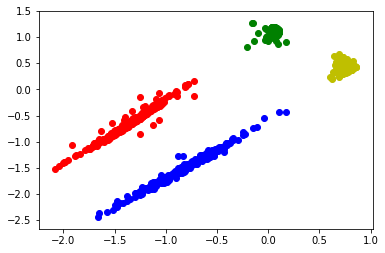

VAL_LOSS: 0.6230007410049438
Train Epoch: 45 [95000/99999 (95%)]	Loss: 0.69008446
Train Epoch: 46 [95000/99999 (95%)]	Loss: 0.62897342


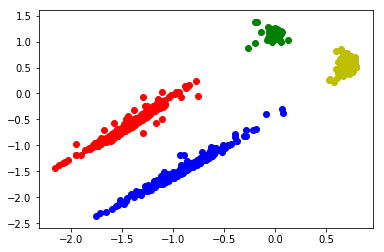

VAL_LOSS: 0.6228220462799072
Train Epoch: 47 [95000/99999 (95%)]	Loss: 0.66053158
Train Epoch: 48 [95000/99999 (95%)]	Loss: 0.63857836


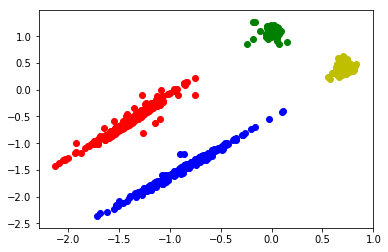

VAL_LOSS: 0.6229733824729919
Train Epoch: 49 [95000/99999 (95%)]	Loss: 0.67948484
Train Epoch: 50 [95000/99999 (95%)]	Loss: 0.67448890


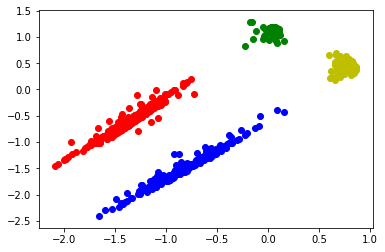

VAL_LOSS: 0.6220020651817322
Train Epoch: 51 [95000/99999 (95%)]	Loss: 0.64304465
Train Epoch: 52 [95000/99999 (95%)]	Loss: 0.62808871


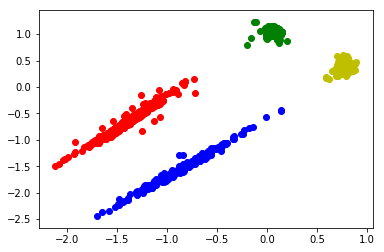

VAL_LOSS: 0.6214562058448792
Train Epoch: 53 [95000/99999 (95%)]	Loss: 0.57959276
Train Epoch: 54 [95000/99999 (95%)]	Loss: 0.71359116


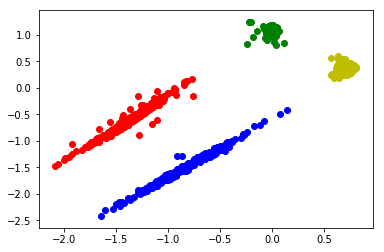

VAL_LOSS: 0.6216553449630737
Train Epoch: 55 [95000/99999 (95%)]	Loss: 0.67478776
Train Epoch: 56 [95000/99999 (95%)]	Loss: 0.64853132


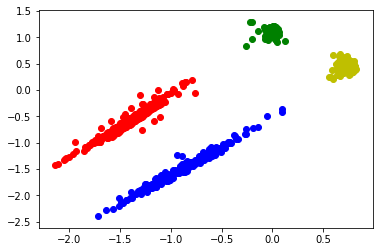

VAL_LOSS: 0.6218653321266174
Train Epoch: 57 [95000/99999 (95%)]	Loss: 0.61515933
Train Epoch: 58 [95000/99999 (95%)]	Loss: 0.70595562


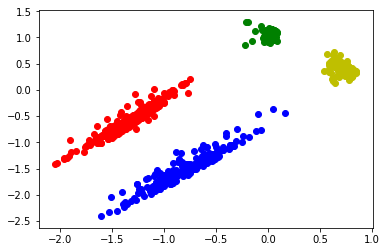

VAL_LOSS: 0.6217533946037292
Train Epoch: 59 [95000/99999 (95%)]	Loss: 0.62373883
Train Epoch: 60 [95000/99999 (95%)]	Loss: 0.58636302


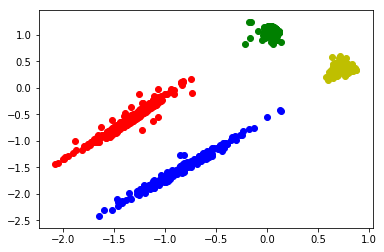

VAL_LOSS: 0.6215943098068237
Train Epoch: 61 [95000/99999 (95%)]	Loss: 0.68458217
Train Epoch: 62 [95000/99999 (95%)]	Loss: 0.59541285


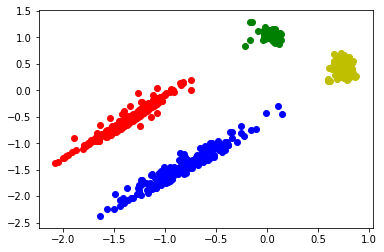

VAL_LOSS: 0.6229586005210876
Train Epoch: 63 [95000/99999 (95%)]	Loss: 0.67543966
Train Epoch: 64 [95000/99999 (95%)]	Loss: 0.67734343


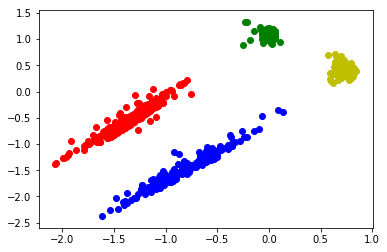

VAL_LOSS: 0.621647834777832
Train Epoch: 65 [95000/99999 (95%)]	Loss: 0.62840104
Train Epoch: 66 [95000/99999 (95%)]	Loss: 0.67309666


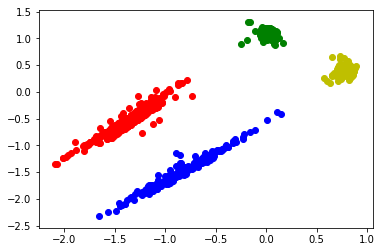

VAL_LOSS: 0.6208032369613647
Train Epoch: 67 [95000/99999 (95%)]	Loss: 0.68323541
Train Epoch: 68 [95000/99999 (95%)]	Loss: 0.67730963


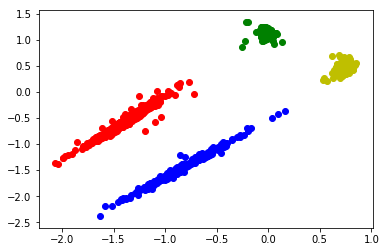

VAL_LOSS: 0.622782289981842
Train Epoch: 69 [95000/99999 (95%)]	Loss: 0.62788534
Train Epoch: 70 [95000/99999 (95%)]	Loss: 0.69174439


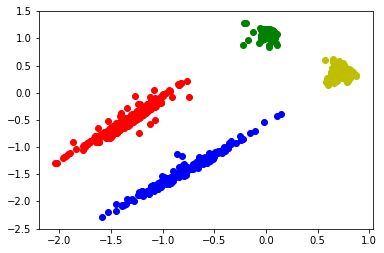

VAL_LOSS: 0.6215854287147522
Train Epoch: 71 [95000/99999 (95%)]	Loss: 0.74093086
Train Epoch: 72 [95000/99999 (95%)]	Loss: 0.64033335


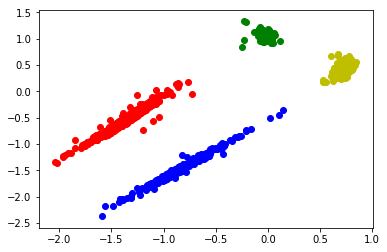

VAL_LOSS: 0.6220706105232239
Train Epoch: 73 [95000/99999 (95%)]	Loss: 0.71243083
Train Epoch: 74 [95000/99999 (95%)]	Loss: 0.64487606


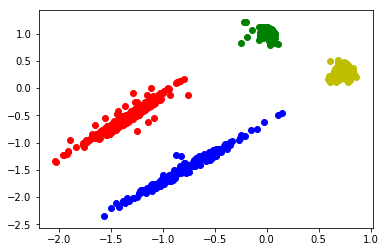

VAL_LOSS: 0.6215279698371887
Train Epoch: 75 [95000/99999 (95%)]	Loss: 0.63795596
Train Epoch: 76 [95000/99999 (95%)]	Loss: 0.65845782


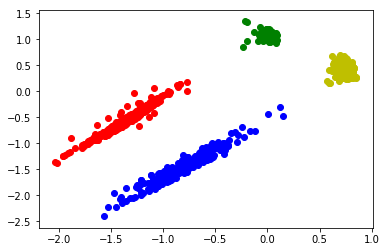

VAL_LOSS: 0.6214771866798401
Train Epoch: 77 [95000/99999 (95%)]	Loss: 0.60489541
Train Epoch: 78 [95000/99999 (95%)]	Loss: 0.71986693


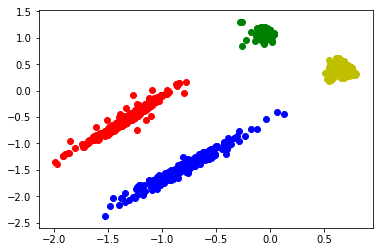

VAL_LOSS: 0.6212108731269836
Train Epoch: 79 [95000/99999 (95%)]	Loss: 0.67209965
Train Epoch: 80 [95000/99999 (95%)]	Loss: 0.68253714


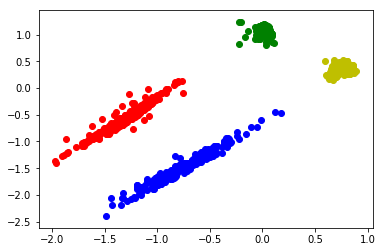

VAL_LOSS: 0.6211457848548889
Train Epoch: 81 [95000/99999 (95%)]	Loss: 0.62172973
Train Epoch: 82 [95000/99999 (95%)]	Loss: 0.64490938


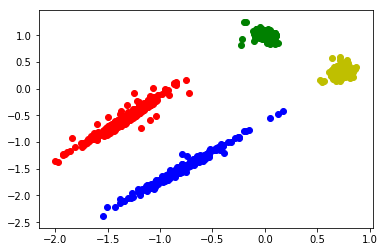

VAL_LOSS: 0.6208674311637878
Train Epoch: 83 [95000/99999 (95%)]	Loss: 0.60819489
Train Epoch: 84 [95000/99999 (95%)]	Loss: 0.59307826


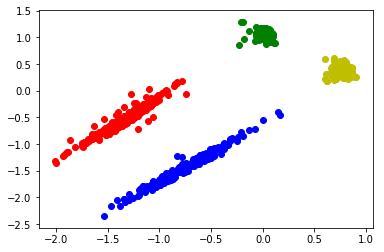

VAL_LOSS: 0.6217503547668457
Train Epoch: 85 [95000/99999 (95%)]	Loss: 0.67924380
Train Epoch: 86 [95000/99999 (95%)]	Loss: 0.69555438


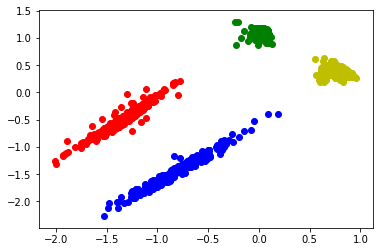

VAL_LOSS: 0.6229228973388672
Train Epoch: 87 [95000/99999 (95%)]	Loss: 0.59862053
Train Epoch: 88 [95000/99999 (95%)]	Loss: 0.63854229


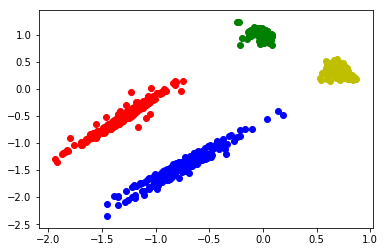

VAL_LOSS: 0.6216737031936646
Train Epoch: 89 [95000/99999 (95%)]	Loss: 0.65278280
Train Epoch: 90 [95000/99999 (95%)]	Loss: 0.75356203


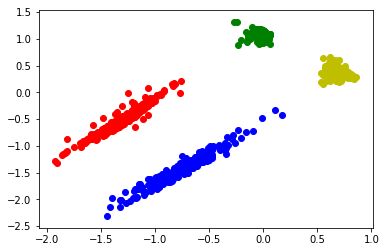

VAL_LOSS: 0.6209905743598938
Train Epoch: 91 [95000/99999 (95%)]	Loss: 0.68687981
Train Epoch: 92 [95000/99999 (95%)]	Loss: 0.63202339


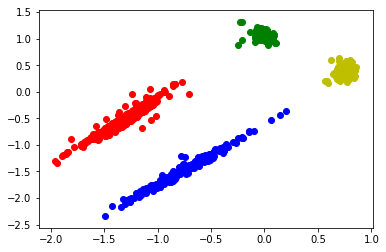

VAL_LOSS: 0.6206744909286499
Train Epoch: 93 [95000/99999 (95%)]	Loss: 0.63127404
Train Epoch: 94 [95000/99999 (95%)]	Loss: 0.59930414


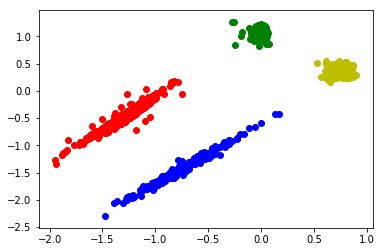

VAL_LOSS: 0.6223360896110535
Train Epoch: 95 [95000/99999 (95%)]	Loss: 0.64287192
Train Epoch: 96 [95000/99999 (95%)]	Loss: 0.64698875


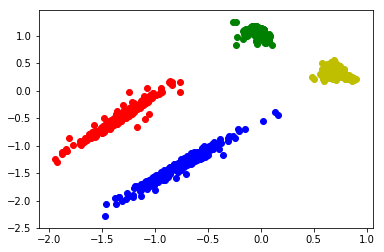

VAL_LOSS: 0.6212960481643677
Train Epoch: 97 [95000/99999 (95%)]	Loss: 0.65137702
Train Epoch: 98 [95000/99999 (95%)]	Loss: 0.69255072


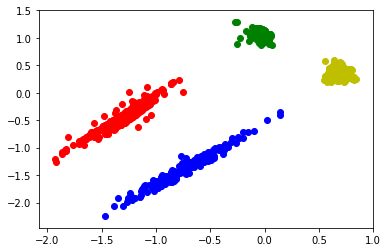

VAL_LOSS: 0.6215059757232666
Train Epoch: 99 [95000/99999 (95%)]	Loss: 0.64686561
Train Epoch: 100 [95000/99999 (95%)]	Loss: 0.64954042


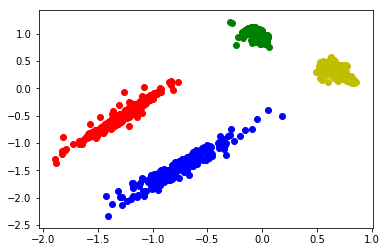

VAL_LOSS: 0.6214013695716858
Train Epoch: 101 [95000/99999 (95%)]	Loss: 0.59821177
Train Epoch: 102 [95000/99999 (95%)]	Loss: 0.66306680


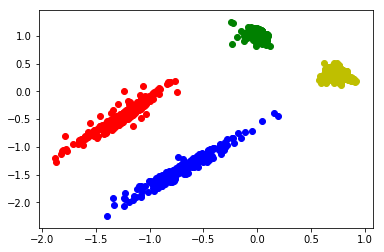

VAL_LOSS: 0.621209442615509
Train Epoch: 103 [95000/99999 (95%)]	Loss: 0.69398713
Train Epoch: 104 [95000/99999 (95%)]	Loss: 0.64556903


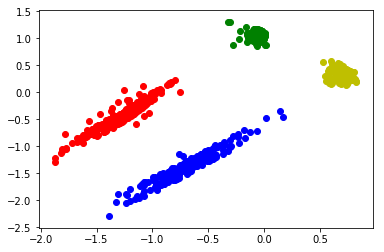

VAL_LOSS: 0.620995044708252
Train Epoch: 105 [95000/99999 (95%)]	Loss: 0.63200754
Train Epoch: 106 [95000/99999 (95%)]	Loss: 0.56992507


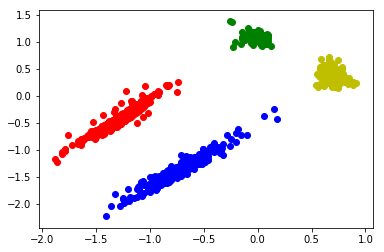

VAL_LOSS: 0.6226206421852112
Train Epoch: 107 [95000/99999 (95%)]	Loss: 0.67732471
Train Epoch: 108 [95000/99999 (95%)]	Loss: 0.61387491


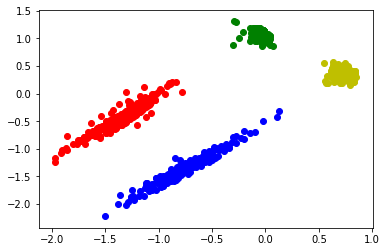

VAL_LOSS: 0.6219666004180908
Train Epoch: 109 [95000/99999 (95%)]	Loss: 0.67800283
Train Epoch: 110 [95000/99999 (95%)]	Loss: 0.59783351


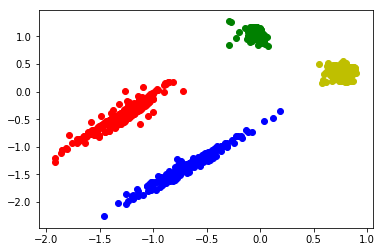

VAL_LOSS: 0.6219176650047302
Train Epoch: 111 [95000/99999 (95%)]	Loss: 0.63641697
Train Epoch: 112 [95000/99999 (95%)]	Loss: 0.65755093


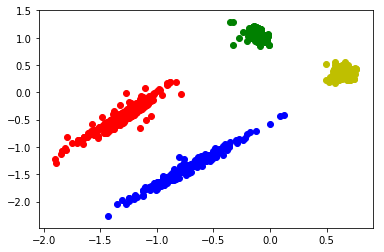

VAL_LOSS: 0.621507465839386
Train Epoch: 113 [95000/99999 (95%)]	Loss: 0.62436301
Train Epoch: 114 [95000/99999 (95%)]	Loss: 0.69614857


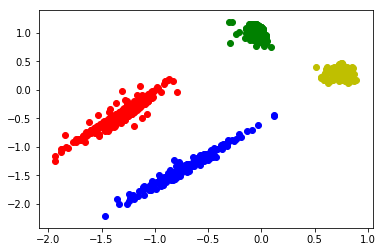

VAL_LOSS: 0.6209734082221985
Train Epoch: 115 [95000/99999 (95%)]	Loss: 0.71372467
Train Epoch: 116 [95000/99999 (95%)]	Loss: 0.66971833


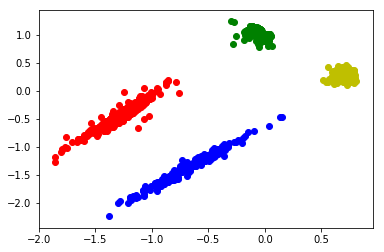

VAL_LOSS: 0.620286762714386
Train Epoch: 117 [95000/99999 (95%)]	Loss: 0.66494596
Train Epoch: 118 [95000/99999 (95%)]	Loss: 0.68831980


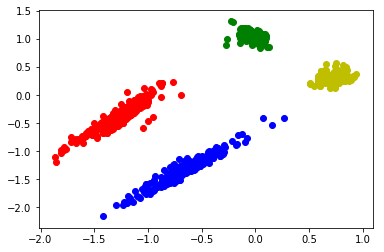

VAL_LOSS: 0.6200650930404663
Train Epoch: 119 [95000/99999 (95%)]	Loss: 0.64978999
Train Epoch: 120 [95000/99999 (95%)]	Loss: 0.68227196


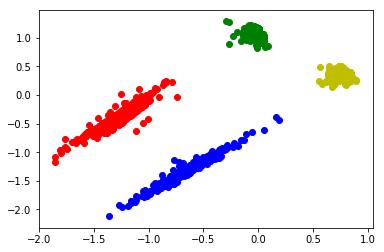

VAL_LOSS: 0.621849536895752
Train Epoch: 121 [95000/99999 (95%)]	Loss: 0.66676062
Train Epoch: 122 [95000/99999 (95%)]	Loss: 0.64587027


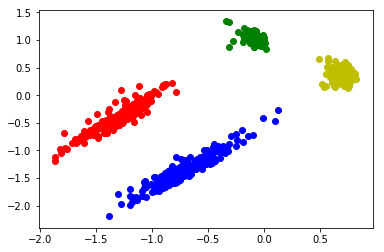

VAL_LOSS: 0.6214457750320435
Train Epoch: 123 [95000/99999 (95%)]	Loss: 0.61741686
Train Epoch: 124 [95000/99999 (95%)]	Loss: 0.63566095


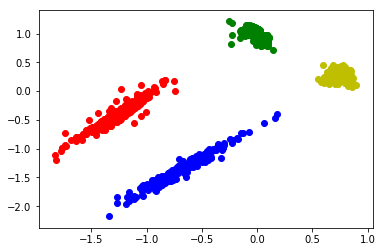

VAL_LOSS: 0.6209256649017334
Train Epoch: 125 [95000/99999 (95%)]	Loss: 0.68821144
Train Epoch: 126 [95000/99999 (95%)]	Loss: 0.66132861


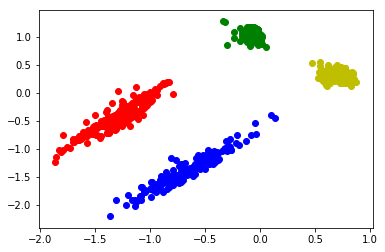

VAL_LOSS: 0.6221804618835449
Train Epoch: 127 [95000/99999 (95%)]	Loss: 0.61687225
Train Epoch: 128 [95000/99999 (95%)]	Loss: 0.67678124


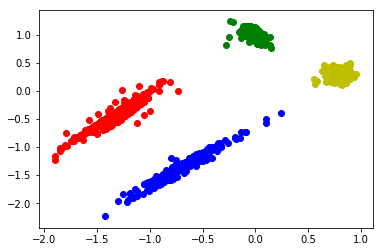

VAL_LOSS: 0.6207940578460693
Train Epoch: 129 [95000/99999 (95%)]	Loss: 0.67105615
Train Epoch: 130 [95000/99999 (95%)]	Loss: 0.61021328


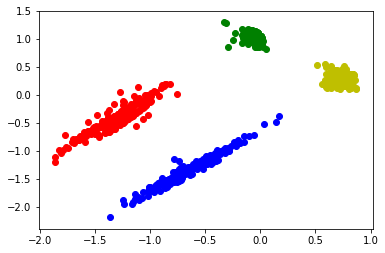

VAL_LOSS: 0.6217066645622253
Train Epoch: 131 [95000/99999 (95%)]	Loss: 0.65473706
Train Epoch: 132 [10000/99999 (10%)]	Loss: 0.64353353

KeyboardInterrupt: 

In [26]:
# train encoder and decoder
# save and load model
epochs = 1000

try:
    encoder, decoder = torch.load('./model/dimredux_1.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

train_losses = []
val_losses = []
#val_loss = evaluate() 
#val_losses.append(val_loss)
eval_plot()
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    for batch_idx, (x,y) in enumerate(data_loader):
        batchsize = x.size()[0]
        x,y = Variable(x),Variable(y)

        optimizer.zero_grad()
        output = encoder(x)
        output = decoder(output)
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
            
        if batch_idx % 10 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * batch_size, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss),end='')
        
    print()
    if epoch % 2 == 0:
        pass
        eval_plot()
    # val_loss = evaluate() 
    # val_losses.append(val_loss)
    # if val_loss < val_losses[-2]:
    #     print("taking snapshot")
    #     torch.save([encoder,decoder],'./model/deno_autoencoder-0_79.pkl')

In [249]:
learning_rate *= 0.01
data_loader = utils.DataLoader(lagged_dset, batch_size=batch_size*10, shuffle=True)

In [44]:
def predict_class(test_x, validation_x, val_y):
    val_set = timeLaggedDataset(validation_x,x_lag,y_lag,overlay)
    val_loader = utils.DataLoader(val_set, batch_size=len(val_set), shuffle=False)
    #print(len(val_set))
    
    test_set = timeLaggedDataset(test_x,x_lag,y_lag,overlay)
    test_loader = utils.DataLoader(test_set, batch_size=len(test_set), shuffle=False)
    
    # # Encode all data
    encoder.eval()
    for x,y in val_loader:
        val_out = encoder(x)
    
    for x,y in test_loader:
        test_out = encoder(x)
        
    #print(val_out.size())  
    #print(test_out.size())
    
    val_out = val_out.detach().numpy()
    test_out = test_out.detach().numpy()
    
    val_out, test_out = whiten(val_out,test_out)
    
    # # get cluster means on reduced 2 dimensions
    mean = np.zeros((4,2))
    for i in range(4):
        print((validation_y == i).shape)
        mean[i] = val_out[(validation_y[:-x_lag] == i)].mean(axis=0)
    
    print("Means: ", mean)
    pred_val_mtrx = np.zeros((len(val_set),4))
    pred_test_mtrx = np.zeros((len(test_set),4))
    for i in range(4):
        pred_val_mtrx[:,i] = np.linalg.norm((val_out - mean[i]),axis=1)
        pred_test_mtrx[:,i] = np.linalg.norm(test_out - mean[i],axis=1)#[:,0]
    
    pred_val = np.argmin(np.abs(pred_val_mtrx),axis=1)
    pred_test = np.argmin(np.abs(pred_test_mtrx),axis=1)
    
    acc = (pred_val == validation_y[:-x_lag]).mean()
    print("Accuracy: ", acc)
    return pred_test, pred_val
    
pred_test, pred_val = predict_class(data_x_white,validation_x_white,validation_y)    
    

(1000,)
(1000,)
(1000,)
(1000,)
Means:  [[ 0.95744908 -0.85329509]
 [ 0.79704934  1.0115639 ]
 [-1.21436262  0.85830945]
 [-1.00298727 -1.17369902]]
Accuracy:  0.996996996997


In [48]:
final_pred = np.empty(100000,dtype=int)
final_pred[:-1] = pred_test
final_pred[-1] = pred_test[-2]
assert final_pred.ndim == 1
assert final_pred.shape[0] == 100000

In [51]:
# AND SAVE EXACTLY AS SHOWN BELOW
np.save('./u7/prediction.npy', final_pred)

In [52]:
encoder

Encoder(
  (fclayers): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [53]:
decoder

Decoder(
  (fclayers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)